## Imports and Initalization

* Install Styleformer from Github
* Load Libraries (we use Bert with pytorch)
* Define Hyperparameters
* Download Preprocessing libraries/vocabularies using nltk

In [1]:
!pip install git+https://github.com/PrithivirajDamodaran/Styleformer.git

  Cloning https://github.com/PrithivirajDamodaran/Styleformer.git to /private/var/folders/6w/6hnvrrg501z8ycmdvfyk59n00000gn/T/pip-req-build-i0ldnjqn
  Running command git clone --filter=blob:none --quiet https://github.com/PrithivirajDamodaran/Styleformer.git /private/var/folders/6w/6hnvrrg501z8ycmdvfyk59n00000gn/T/pip-req-build-i0ldnjqn
  Resolved https://github.com/PrithivirajDamodaran/Styleformer.git to commit 02c9a7fd6798bf5bbbb04456e5068566d6caef55
  Preparing metadata (setup.py) ... done


In [2]:
import os

import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import TensorDataset, DataLoader

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
)

import seaborn as sns
from matplotlib.pylab import plt

import nltk

from styleformer import Styleformer, Adequacy

from google.colab import drive

/Users/marcbruni/snu/nlp/nlp-project-2023/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
drive.mount("/content/drive")
nltk.download("stopwords")
nltk.download("punkt")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    raise ValueError("Cuda or Apple Metal required but neither is available.")
print(f"Using device: {device}")

Using device: mps


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marcbruni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/marcbruni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Define hyperparameters
# Dataset taken from: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification
# TODO: maybe download dynamically -> would require login to kaggle
DATASET_PATH = "/content/drive/MyDrive/NLP-Project/WELFake_Dataset.csv"
TEST_SIZE = 0.1
TRAIN_EPOCHS = 10
TRAIN_BATCH_SIZE = 32
BERT_MODEL = "bert-base-uncased"
NUM_WORKERS = 2
SEED = 42

## Data Loading / Exploration / Preprocessing

* Load data
* Drop unused Columns (index column)
* Concatenate title and content of news article
* Look how well the dataset is balanced
* Tokenize
* Create Tensor for finetuning Bert including test and train set

In [5]:
df = pd.read_csv(DATASET_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [6]:
# Drop index numbering
df = df.drop(["Unnamed: 0"], axis=1)

# Find duplicates
raw_size = df.shape[0]
df = df.drop_duplicates()
cleaned_size = df.shape[0]
print(f"Removed {raw_size - cleaned_size} duplicates from the dataset")

# Concatenate title and text
raw_size = df.shape[0]
df["all_text"] = df["title"] + "\n\n\n\n" + df["text"]
df = df[~df["all_text"].isnull()]
cleaned_size = df.shape[0]
print(f"Removed {raw_size - cleaned_size} null values from the dataset")

print(f"Shape of the dataset: {df.shape}")

Removed 8456 duplicates from the dataset
Removed 557 null values from the dataset
Shape of the dataset: (63121, 4)


In [7]:
df.head(10)

,title,text,label,all_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,About Time! Christian Group Sues Amazon and SP...
6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,1,DR BEN CARSON TARGETED BY THE IRS: “I never ha...
7,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,1,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...
8,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",1,Sports Bar Owner Bans NFL Games…Will Show Only...
9,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",1,Latest Pipeline Leak Underscores Dangers Of Da...
10,GOP Senator Just Smacked Down The Most Puncha...,The most punchable Alt-Right Nazi on the inter...,1,GOP Senator Just Smacked Down The Most Puncha...


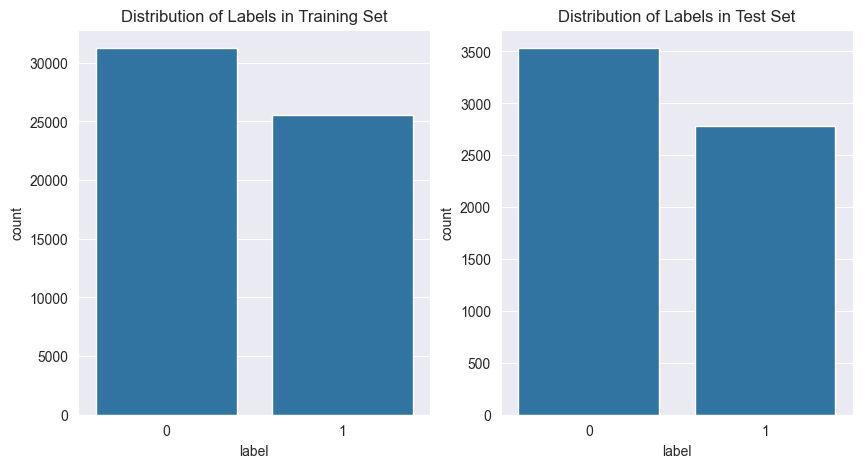

In [8]:
# Create test train split (with shuffeling)
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
train, test = train_test_split(df, test_size=TEST_SIZE, random_state=SEED)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x="label", data=train)
plt.title("Distribution of Labels in Training Set")

plt.subplot(1, 2, 2)
sns.countplot(x="label", data=test)
plt.title("Distribution of Labels in Test Set")

plt.show()

In [9]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

In [10]:
def tokenize_texts(df, feature="all_text"):
    input_ids = []
    attention_masks = []

    for text in df[feature]:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=64,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
            truncation=True,
        )

        input_ids.append(encoded_dict["input_ids"])

        attention_masks.append(encoded_dict["attention_mask"])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks


def create_tensor_dataset(df, feature="all_text"):
    input_ids, attention_masks = tokenize_texts(df, feature=feature)
    labels = torch.tensor(df["label"].values)

    return TensorDataset(input_ids, attention_masks, labels)

In [11]:
train_dataset = create_tensor_dataset(train)
test_dataset = create_tensor_dataset(test)

## Model Loading and Training

* Load Bert
* Finetune model on train set

In [12]:
model = BertForSequenceClassification.from_pretrained(
    BERT_MODEL, num_labels=2, output_attentions=False, output_hidden_states=False
)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-6, eps=1e-8)

In [14]:
train_loader = DataLoader(dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [15]:
total_steps = len(train_loader) * TRAIN_EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
model.train()

total_step = len(train_loader)
for epoch in range(TRAIN_EPOCHS):
    start_time = time.time()
    total_loss = 0
    for i, (ids, masks, labels) in enumerate(train_loader):
        ids = ids.to(device)
        masks = masks.to(device)
        labels = labels.to(device)

        loss = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    end_time = time.time()
    epoch_time = end_time - start_time 
    loss_per_step = total_loss / total_step
    print(f"{epoch + 1} epoch with loss: {loss_per_step:.4f}, duration: {epoch_time:.2f} seconds")

if not os.path.exists("model"):
    os.makedirs("model")
torch.save(model.state_dict(), "model/BERT_finetuned.ckpt")

## Evaluation

* Evaluate finetuned model on test set

In [78]:
def eval_model(df):
    loader = DataLoader(dataset=df, batch_size=1, shuffle=False)
    model.eval()
    model.load_state_dict(torch.load("model/BERT_finetuned.ckpt", map_location=device))

    score = 0
    pred = []
    gt = []
    for i, (ids, masks, labels) in enumerate(loader):
        ids = ids.to(device)
        masks = masks.to(device)
        labels = labels.to(device)

        g_labels = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)[1]

        pred.append(torch.max(g_labels, 1)[1][0].item())
        gt.append(labels[0].item())


    cm = confusion_matrix(gt, pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()
    plt.show()

    acc = sum([int(pred[i] == gt[i]) for i in range(len(pred))]) / len(df)
    print(f"Accuracy: {acc:.4f}\n")

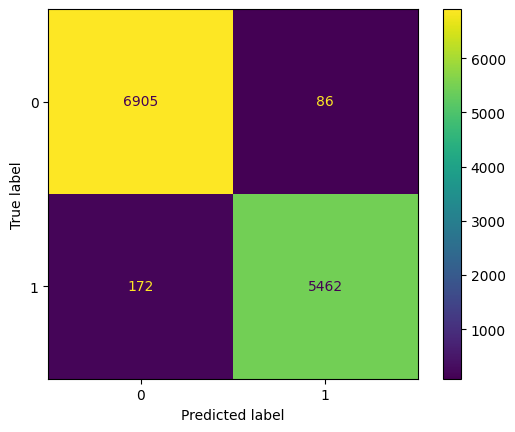

Accuracy: 0.9796


In [79]:
eval_model(test_dataset)

## Style Transfer

* Load styleformer model
* Filter for fake news test set
* Transform style of test set from casual to formal
* Evaluate model on fake news and style transformed fake news and compare

In [51]:
test_fake_news = test[test["label"] == 0][:100]
test_fake_news.shape

(10, 4)

In [52]:
CTF_MODEL_TAG = "prithivida/informal_to_formal_styletransfer"
ADEQUACY_MODEL_TAG = "prithivida/parrot_adequacy_model"

MAX_CANDIDATES = 5

In [53]:
ctf_tokenizer = AutoTokenizer.from_pretrained(CTF_MODEL_TAG, use_auth_token=False)
ctf_model = AutoModelForSeq2SeqLM.from_pretrained(CTF_MODEL_TAG, use_auth_token=False)
adequacy = Adequacy(model_tag=ADEQUACY_MODEL_TAG)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:671: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


In [54]:
def apply_st_to_sentence(src_sentence):
    ctf_prefix = "transfer Casual to Formal: "
    input_sentence = ctf_prefix + src_sentence
    input_ids = ctf_tokenizer.encode(input_sentence, return_tensors="pt")

    preds = ctf_model.generate(
        input_ids,
        do_sample=True,
        max_length=32,
        top_k=10,
        top_p=0.95,
        early_stopping=False,
        num_return_sequences=MAX_CANDIDATES,
    )

    gen_sentences = set()
    for pred in preds:
        gen_sentences.add(ctf_tokenizer.decode(pred, skip_special_tokens=True).strip())

    adequacy_scored_phrases = adequacy.score(src_sentence, list(gen_sentences), 0, device)
    ranked_sentences = sorted(adequacy_scored_phrases.items(), key=lambda x: x[1], reverse=True)
    return ranked_sentences[0][0]


def apply_st_to_paragraph(input_sentence):
    sentences = nltk.sent_tokenize(input_sentence)
    sentences_transformed = []
    for sentence in sentences:
        sentences_transformed.append(apply_st_to_sentence(sentence))

    concatenated_sentences = " ".join(sentences_transformed).strip()
    if not concatenated_sentences:
        print("empty:")
        print(concatenated_sentences)

    return concatenated_sentences


test_fake_news["st_title"] = test_fake_news["title"].apply(apply_st_to_paragraph)
test_fake_news["st_text"] = test_fake_news["text"].apply(apply_st_to_paragraph)
test_fake_news["st_all_text"] = test_fake_news["st_title"] + "\n\n\n\n" + test_fake_news["st_text"]

Zimbabwe's Mugabe to meet military commanders for talks on Sunday. State TV.
The recent backlash against Clinton over email use creates an opening for Trump.
Trump criticized lobbyists, but now they are part of his transition team.
McConnell says the debate on the debt ceiling could extend into September.
YRC Worldwide has limited operations in Florida terminals.
Priebus Take Trump Seriously When He Calls Media 'The Enemy.'
Austria's conservatives demonstrate little fear about teaming up with the far right
Obama Unlikely to Vow No First Use of Nuclear Weapons. The New York Times.
The post Hashtags, Polls, and Putin after the debate was in The New York Times.
#MayorsStand4All Day touts Support for Illegal Immigrants
Zimbabwe's president Robert Mugabe will meet military commanders for talks on Sunday, state broadcaster ZTV said on Saturday.
The FBI report scolding Democrat Hillary Clinton over her email practices as secretary of state plays into a chief vulnerability that her rival, Repu

In [55]:
test_fake_news.head(10)

,title,text,label,all_text,st_title,st_text,st_all_text
62508,Zimbabwe's Mugabe to meet military commanders ...,HARARE (Reuters) - Zimbabwe s President Robert...,0,Zimbabwe's Mugabe to meet military commanders ...,Zimbabwe's Mugabe to meet military commanders ...,Zimbabwe's president Robert Mugabe will meet m...,Zimbabwe's Mugabe to meet military commanders ...
11200,Rebuke of Clinton over email use creates openi...,WASHINGTON (Reuters) - The FBI report scolding...,0,Rebuke of Clinton over email use creates openi...,The recent backlash against Clinton over email...,The FBI report scolding Democrat Hillary Clint...,The recent backlash against Clinton over email...
36045,"Trump Campaigned Against Lobbyists, but Now Th...","WASHINGTON — Donald J. Trump, who campaig...",0,"Trump Campaigned Against Lobbyists, but Now Th...","Trump criticized lobbyists, but now they are p...",Donald J. Trump is filling his transition team...,"Trump criticized lobbyists, but now they are p..."
19599,McConnell says U.S. debt ceiling debate could ...,WASHINGTON (Reuters) - U.S. Senate Majority Le...,0,McConnell says U.S. debt ceiling debate could ...,McConnell says the debate on the debt ceiling ...,Washington (Reuters) - The U.S. Senate Majorit...,McConnell says the debate on the debt ceiling ...
8721,YRC Worldwide has limited operations in Florid...,(Reuters) - YRC Worldwide Inc resumed limited ...,0,YRC Worldwide has limited operations in Florid...,YRC Worldwide has limited operations in Florid...,YRC Worldwide Inc resumed limited operations a...,YRC Worldwide has limited operations in Florid...
24990,Priebus: Take Trump Seriously When he Calls Me...,"Sunday on CBS’s “Face the Nation,” White House...",0,Priebus: Take Trump Seriously When he Calls Me...,Priebus Take Trump Seriously When He Calls Med...,"On the CBS show 'Face the Nation' on Sunday, R...",Priebus Take Trump Seriously When He Calls Med...
62931,Austria's conservatives show few qualms about ...,VIENNA (Reuters) - With conservative leader Se...,0,Austria's conservatives show few qualms about ...,Austria's conservatives demonstrate little fea...,With conservative leader Sebastian Kurz winnin...,Austria's conservatives demonstrate little fea...
28592,Obama Unlikely to Vow No First Use of Nuclear ...,"President Obama, who has weighed ruling out a ...",0,Obama Unlikely to Vow No First Use of Nuclear ...,Obama Unlikely to Vow No First Use of Nuclear ...,"President Obama, who has considered ruling out...",Obama Unlikely to Vow No First Use of Nuclear ...
2527,"Hashtags, Polls and Putin: Aftermath of the Vi...","The debate may be in the books, but the sp...",0,"Hashtags, Polls and Putin: Aftermath of the Vi...","The post Hashtags, Polls, and Putin after the ...","The debate may be in the books, but the spin c...","The post Hashtags, Polls, and Putin after the ..."
2777,#MayorsStand4All Day Touts Support for Illegal...,Sixty mayors from around the country on Tuesda...,0,#MayorsStand4All Day Touts Support for Illegal...,#MayorsStand4All Day touts Support for Illegal...,Sixty mayors representing across the country h...,#MayorsStand4All Day touts Support for Illegal...


In [56]:
test_fake_news["st_all_text"]

62508    Zimbabwe's Mugabe to meet military commanders ...
11200    The recent backlash against Clinton over email...
36045    Trump criticized lobbyists, but now they are p...
19599    McConnell says the debate on the debt ceiling ...
8721     YRC Worldwide has limited operations in Florid...
24990    Priebus Take Trump Seriously When He Calls Med...
62931    Austria's conservatives demonstrate little fea...
28592    Obama Unlikely to Vow No First Use of Nuclear ...
2527     The post Hashtags, Polls, and Putin after the ...
2777     #MayorsStand4All Day touts Support for Illegal...
Name: st_all_text, dtype: object

In [75]:
untransferred_dataset = create_tensor_dataset(test_fake_news)
transferred_dataset = create_tensor_dataset(test_fake_news, "st_all_text")

Without style transfer:


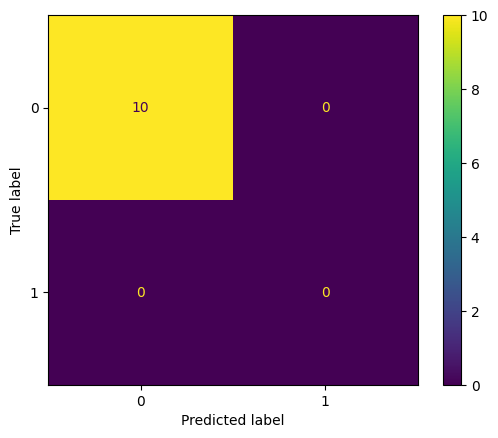

Accuracy: 1.0000


In [80]:
print("Without style transfer:\n")
eval_model(untransferred_dataset)

With style transfer:


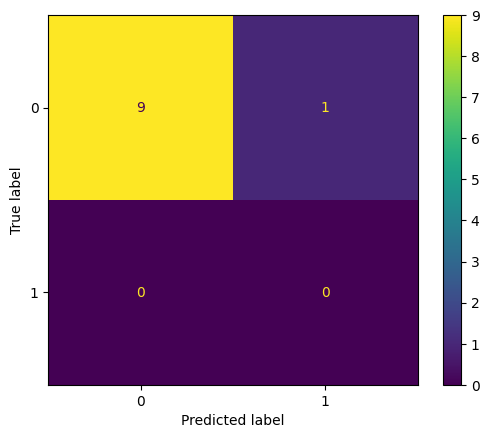

Accuracy: 0.9000


In [81]:
print("With style transfer:\n")
eval_model(transferred_dataset)